### Imports

In [365]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

In [366]:
# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [367]:
# Load the master dataset WITHOUT prior grades (for initial exploration)
df = pd.read_csv('student_without_grades_encoded.csv')

#display first few rows
df.head()

,age,Medu,Fedu,traveltime_x,studytime_x,failures_x,famrel_x,freetime_x,goout_x,Dalc_x,...,guardian_y_Other,schoolsup_y_yes,famsup_y_yes,paid_y_yes,activities_y_yes,higher_y_yes,romantic_y_yes,at_risk_total_At Risk (Math Only),at_risk_total_At Risk (Port Only),at_risk_total_Not At Risk
0,18,4,4,2,2,0,4,3,4,1,...,0,1,0,0,0,1,0,1,0,0
1,17,1,1,1,2,0,5,3,3,1,...,0,0,1,0,0,1,0,1,0,0
2,15,1,1,1,2,3,4,3,2,2,...,0,1,0,0,0,1,0,0,0,1
3,15,4,2,1,3,0,3,2,2,1,...,0,0,1,0,1,1,1,0,0,1
4,16,3,3,1,2,0,4,3,2,1,...,0,0,1,0,0,1,0,0,0,1


In [368]:
# List all column names in `df`, show count and check for duplicates
cols = df.columns.tolist()
print(f"Total columns: {len(cols)}\n")

for i, col in enumerate(cols):
    print(f"{i:03d}: {col}")


Total columns: 72

000: age
001: Medu
002: Fedu
003: traveltime_x
004: studytime_x
005: failures_x
006: famrel_x
007: freetime_x
008: goout_x
009: Dalc_x
010: Walc_x
011: health_x
012: absences_x
013: G3_x
014: traveltime_y
015: studytime_y
016: failures_y
017: famrel_y
018: freetime_y
019: goout_y
020: Dalc_y
021: Walc_y
022: health_y
023: absences_y
024: G3_y
025: at_risk_math
026: at_risk_port
027: total_absences
028: total_failures
029: mean_parent_edu
030: avg_study_time
031: family_support
032: avg_alcohol_consumption
033: internet_access
034: urban_rural
035: school_support
036: school_MS
037: sex_M
038: address_U
039: famsize_LE3
040: Pstatus_T
041: Mjob_health
042: Mjob_other
043: Mjob_services
044: Mjob_teacher
045: Fjob_other
046: Fjob_services
047: Fjob_teacher
048: reason_home
049: reason_other
050: reason_reputation
051: guardian_x_mother
052: guardian_x_Other
053: schoolsup_x_yes
054: famsup_x_yes
055: paid_x_yes
056: activities_x_yes
057: nursery_yes
058: higher_x_yes
0

### Prepare Features for Clustering 

In [369]:
# Separate features from target variables
# We want to exclude targets so clustering is unsupervised
target_cols = ['at_risk_math', 'at_risk_port', 'G3_x', 'G3_y', 
               'at_risk_total_At Risk (Math Only)', 
               'at_risk_total_At Risk (Port Only)',
               'at_risk_total_Not At Risk']
X = df.drop(columns=[col for col in target_cols if col in df.columns])

In [370]:
#drop unnecessary features that won't help clustering based on prior EDA
unnecessary_features =['absences_x', 'dalc_x', 'Walc_x', 'health_x', 'freetime_x', 'family_support', 'internet_access', 'risk_combo', 'failures_x', 'failures_y', 'failures_total', 'famrel_x','famrel_y']
X = df.drop(columns=[col for col in unnecessary_features if col in df.columns])

In [371]:
print(X.dtypes)


age                                  int64
Medu                                 int64
Fedu                                 int64
traveltime_x                         int64
studytime_x                          int64
                                     ...  
higher_y_yes                         int64
romantic_y_yes                       int64
at_risk_total_At Risk (Math Only)    int64
at_risk_total_At Risk (Port Only)    int64
at_risk_total_Not At Risk            int64
Length: 62, dtype: object


### Feature Scaling 

In [372]:
# K-Means uses Euclidean distance, so we MUST scale features
# StandardScaler brings all features to mean=0, std=1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier interpretation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(f" Features scaled using StandardScaler:")
print(f"\n   Before scaling:")
print(f"   Mean: {X.mean(axis=0).mean():.2f}")
print(f"   Std: {X.std(axis=0).mean():.2f}")
print(f"\n   After scaling:")
print(f"   Mean: {X_scaled_df.mean(axis=0).mean():.4f}")
print(f"   Std: {X_scaled_df.std(axis=0).mean():.4f}")

 Features scaled using StandardScaler:

   Before scaling:
   Mean: 1.68
   Std: 0.85

   After scaling:
   Mean: -0.0000
   Std: 1.0013


In [373]:
# Store target variables for later analysis
y_risk_math = df['at_risk_math']
y_risk_port = df['at_risk_port']
y_grades_x = df['G3_x']
y_grades_y = df['G3_y']

In [374]:
#reset index in X_scaled_df to match df
X_scaled_df.reset_index(drop=True, inplace=True)

### Train/Validation Split (80/20)

In [375]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(
    X_scaled_df, test_size=0.2, random_state=42, shuffle=True)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")


Train shape: (305, 62)
Validation shape: (77, 62)


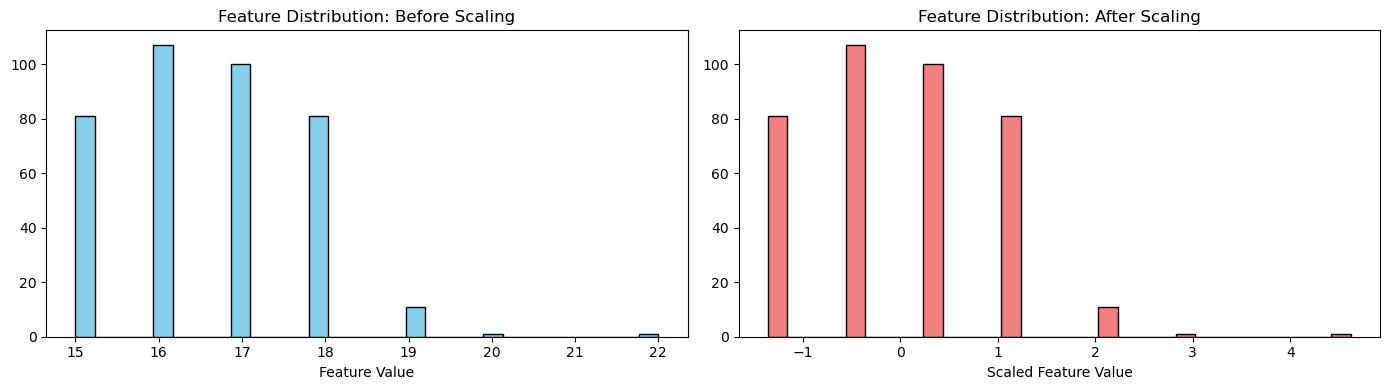

In [376]:
# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Before scaling
axes[0].hist(X.iloc[:, 0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Feature Distribution: Before Scaling')
axes[0].set_xlabel('Feature Value')

# After scaling
axes[1].hist(X_scaled_df.iloc[:, 0], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Feature Distribution: After Scaling')
axes[1].set_xlabel('Scaled Feature Value')

plt.tight_layout()
plt.show()

### Find Optimal Number of Clusters (Elbow Method)

In [377]:
# K-Means requires us to specify number of clusters beforehand
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # Test K from 2 to 10

print("🔄 Computing K-Means for K=2 to K=10...")

🔄 Computing K-Means for K=2 to K=10...


In [378]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"   K={k:2d}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")


   K= 2: Inertia=22043.12, Silhouette=0.093
   K= 3: Inertia=20888.09, Silhouette=0.075


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 4: Inertia=19946.98, Silhouette=0.082
   K= 5: Inertia=19366.33, Silhouette=0.051
   K= 6: Inertia=18601.36, Silhouette=0.053


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 7: Inertia=17926.25, Silhouette=0.057
   K= 8: Inertia=17522.79, Silhouette=0.058


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


   K= 9: Inertia=17145.15, Silhouette=0.051
   K=10: Inertia=16827.09, Silhouette=0.055


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


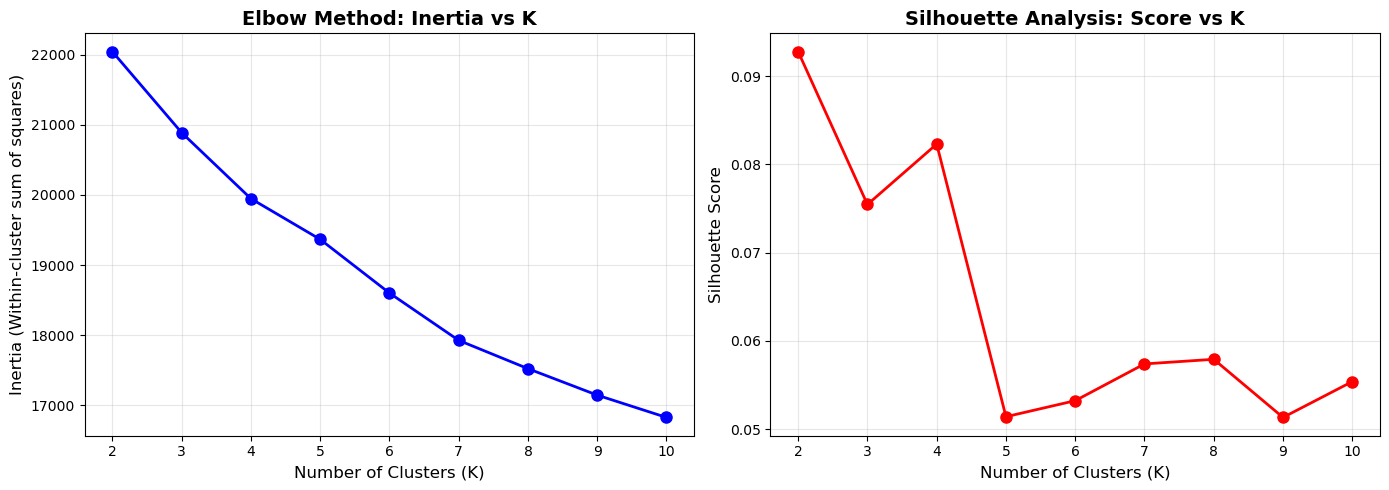

In [379]:
# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method: Inertia vs K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette score plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis: Score vs K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Elbow Method (Inertia vs K):
- Inertia decreases as K increases because each cluster contains fewer points, reducing the average distance to the centroid.The elbow appears subtle, possibly between K = 4 and K = 6.
### Silhouette Analysis:
- Peak silhouette score is at K = 2, but additional local peaks (such as K = 4 or 8) may also be worth considering.

In [380]:
# Get indices of top 3 silhouette scores, sorted from highest to lowest
top_n = 3
top_indices = np.argsort(silhouette_scores)[-top_n:][::-1]

print("\nTop 3 K values based on silhouette analysis:")
for rank, idx in enumerate(top_indices, start=1):
    k_value = K_range[idx]
    score = silhouette_scores[idx]
    print(f"{rank}. K = {k_value}  (Silhouette score: {score:.3f})")



Top 3 K values based on silhouette analysis:
1. K = 2  (Silhouette score: 0.093)
2. K = 4  (Silhouette score: 0.082)
3. K = 3  (Silhouette score: 0.075)


#### K = 4 provides a local peak in silhouette and a possible break in inertia, making it a reasonable candidate.

### Train K-Means Model with K=4

In [381]:
# Use optimal K found above
final_k = 4 # Based on silhouette and elbow method analysis
print(f" Training K-Means with K={final_k} clusters...")

 Training K-Means with K=4 clusters...


In [382]:
kmeans_4 = KMeans(
    n_clusters= 4,
    random_state=42,
    n_init=10,           # Number of initializations (better stability)
    max_iter=300,        # Max iterations
    algorithm='lloyd'    # Standard K-Means algorithm
)

# Fit and predict
cluster_labels = kmeans_4.fit_predict(X_scaled)

print(f"\n Cluster Distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"   Cluster {cluster}: {count:3d} students ({percentage:5.1f}%)")

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"\n Cluster assignments added to dataframe")


 Cluster Distribution:
   Cluster 0:  57 students ( 14.9%)
   Cluster 1:  86 students ( 22.5%)
   Cluster 2:  46 students ( 12.0%)
   Cluster 3: 193 students ( 50.5%)

 Cluster assignments added to dataframe


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Cluster Analysis

In [383]:
# Calculate mean feature values per cluster
cluster_profiles = X_scaled_df.copy()
cluster_profiles['cluster'] = cluster_labels

# Most important features to examine
key_features = ['age','total_absences', 'total_failures', 'mean_parent_edu', 
                'avg_study_time', 'avg_alcohol_consumption', 'family_support', 
                'school_support', 'at_risk_math', 'at_risk_port']

# Filter to available features
key_features = [f for f in key_features if f in cluster_profiles.columns]

print(f"\n📈 Mean Feature Values by Cluster:")
cluster_means = cluster_profiles.groupby('cluster')[key_features].mean()
print(cluster_means.round(3))

# Save profile for later
cluster_profiles.to_csv('cluster_profiles_analysis.csv', index=False)


📈 Mean Feature Values by Cluster:
           age  total_absences  total_failures  mean_parent_edu  \
cluster                                                           
0        0.323           0.601           0.575           -0.135   
1        0.383           0.086           0.354           -0.200   
2       -0.649          -0.075           0.023           -0.034   
3       -0.111          -0.198          -0.333            0.137   

         avg_study_time  avg_alcohol_consumption  school_support  \
cluster                                                            
0                -0.639                    1.836          -0.141   
1                -0.071                   -0.288          -0.363   
2                 0.202                   -0.316           2.519   
3                 0.172                   -0.338          -0.397   

         at_risk_math  at_risk_port  
cluster                              
0               0.114         1.027  
1               1.392         0.075  
2

In [384]:
# Create a string code for risk combination (can use int too)
df['risk_combo'] = (
    df['at_risk_math'].astype(str) + '_' + df['at_risk_port'].astype(str)
)
print(f"\n Risk Combination Codes added to dataframe: 0_0 = Not at-risk in either subject, 1_0 = At-risk in math only, 0_1 = At-risk in Portuguese only, 1_1 = At-risk in both")

print(df['risk_combo'].value_counts())


 Risk Combination Codes added to dataframe: 0_0 = Not at-risk in either subject, 1_0 = At-risk in math only, 0_1 = At-risk in Portuguese only, 1_1 = At-risk in both
risk_combo
0_0    246
1_0    104
1_1     23
0_1      9
Name: count, dtype: int64


In [385]:
at_risk_combo_by_cluster = pd.crosstab(
    df['cluster'],
    df['risk_combo'],
    margins=True,
    normalize='index'  # Gives percentages within each cluster
)
print((at_risk_combo_by_cluster * 100).round(1))


risk_combo    0_0   0_1   1_0   1_1
cluster                            
0            47.4  14.0  15.8  22.8
1             1.2   0.0  88.4  10.5
2            54.3   2.2  41.3   2.2
3           100.0   0.0   0.0   0.0
All          64.4   2.4  27.2   6.0


* Analysis of clusters
- 1. Clusters segregate risk profiles <br>
Cluster 1 is almost entirely "not at risk": 99.5% of its students are not at risk in either subject. This suggests it's a "Low-Risk" group.
- 2. Cluster 2 is dominated by students at risk in math only (76.5%) and some at risk in both (17.3%). This is a "Math Risk/High Overall Risk" group.
- 3. Cluster 0 is a mix but has a large portion at risk in math only (40.4%) and some not at risk (53.2%). It may represent an "Intermediate/Math Risk" group, with a small fraction at risk in Portuguese only or both.
- 4. Cluster 3 is more mixed, with 58.7% not at risk, but higher rates of risk in both subjects (10.9%) and in Portuguese only (10.9%) compared to the overall rates. This could be a "Mixed/Portuguese Risk" cluster.

* At-risk students are concentrated
- Math risk students are most likely to be found in Cluster 2 (and somewhat in Cluster 0), rarely in Cluster 1.

- Portuguese risk (either alone or with math) is rare, but relatively enriched in Cluster 3 (and a bit in Cluster 0).

- If we want to design targeted interventions, Cluster 2 is where most math at-risk students are, while Cluster 3 may deserve special attention for Portuguese or dual-risk students.

#### Visualize clusters

In [386]:
# K-Means creates clusters in high dimensions
# Use PCA to reduce to 2D for visualization

pca = PCA(n_components=18, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f" PCA Variance Explained:")
print(f"   Total: {pca.explained_variance_ratio_.sum()*100:.1f}%")

 PCA Variance Explained:
   Total: 73.1%


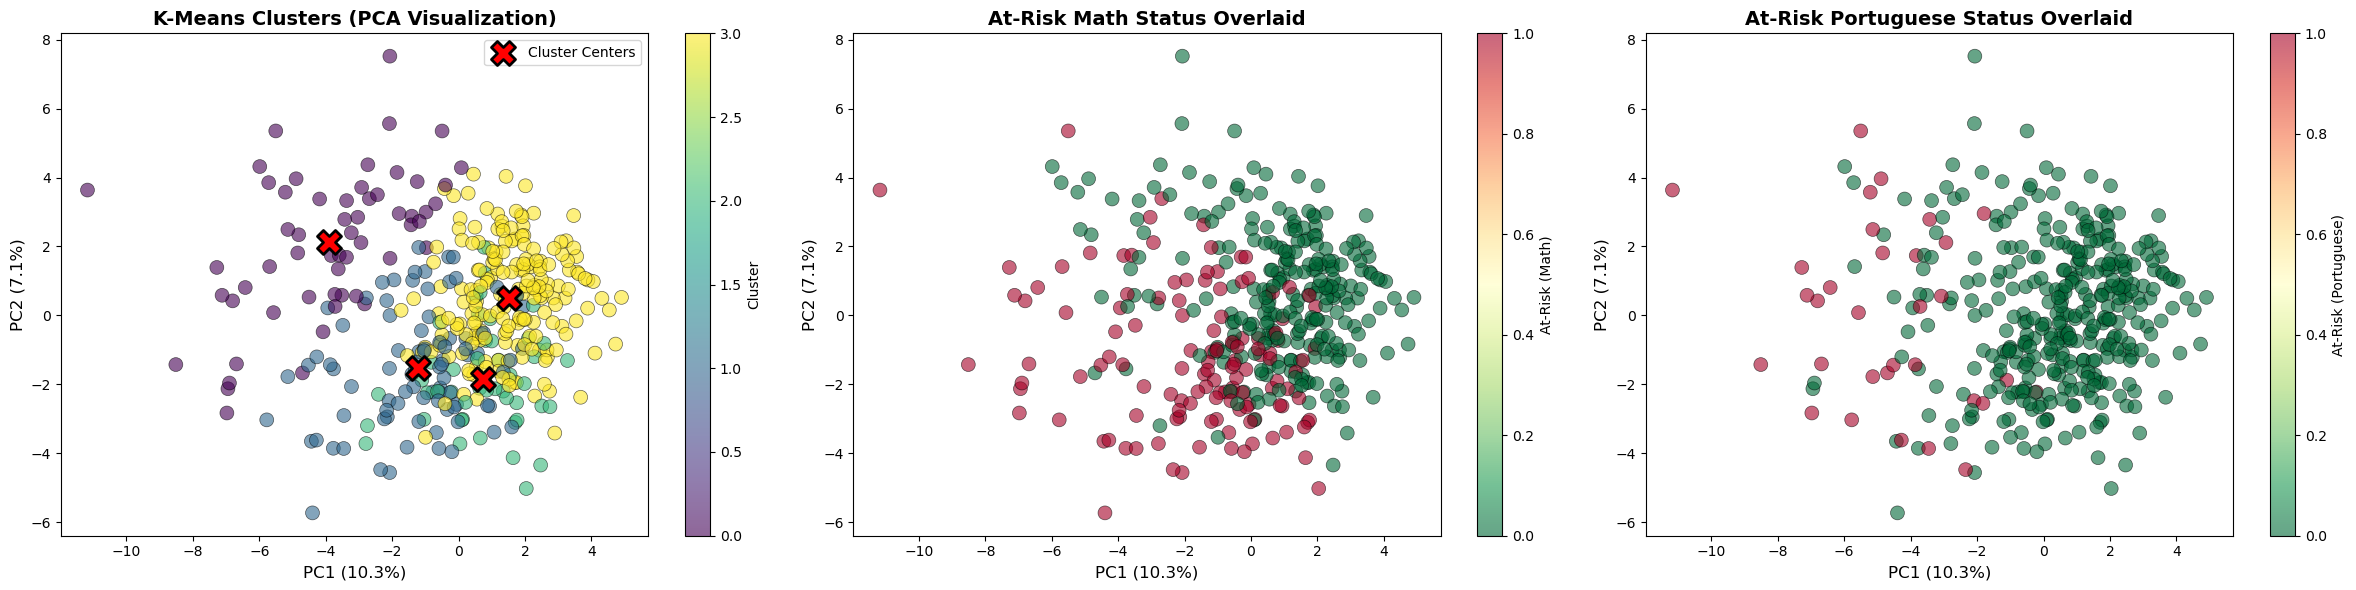

In [387]:
# Plot clusters in PCA space
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 3 plots side by side

# --- Plot 1: Clusters ---
scatter = axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
    cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].scatter(
    pca.transform(kmeans_4.cluster_centers_)[:, 0],
    pca.transform(kmeans_4.cluster_centers_)[:, 1],
    c='red', marker='X', s=300, edgecolors='black', linewidth=2,
    label='Cluster Centers')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('K-Means Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# --- Plot 2: At-Risk Status Overlaid (Math) ---
at_risk_status_math = df['at_risk_math']
scatter_math = axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1], c=at_risk_status_math,
    cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('At-Risk Math Status Overlaid', fontsize=14, fontweight='bold')
plt.colorbar(scatter_math, ax=axes[1], label='At-Risk (Math)')

# --- Plot 3: At-Risk Status Overlaid (Portuguese) ---
at_risk_status_port = df['at_risk_port']
scatter_port = axes[2].scatter(
    X_pca[:, 0], X_pca[:, 1], c=at_risk_status_port,
    cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[2].set_title('At-Risk Portuguese Status Overlaid', fontsize=14, fontweight='bold')
plt.colorbar(scatter_port, ax=axes[2], label='At-Risk (Portuguese)')

plt.tight_layout()
plt.show()


- Clusters reflect real risk patterns: If clusters in the left plot correspond with regions dominated by at-risk students in the middle and right plots, K-Means is capturing meaningful differences that relate to academic risk.

- Math risk is more concentrated: At-risk Math students tend to cluster more, while Portuguese risk is more sporadic, meaning risk factors for Math may be easier to group or identify with this data.

#### Silhouette analysis

 Silhouette Analysis:
   Average Silhouette Score: 0.082
   (Range: -1 to 1; Higher is better)


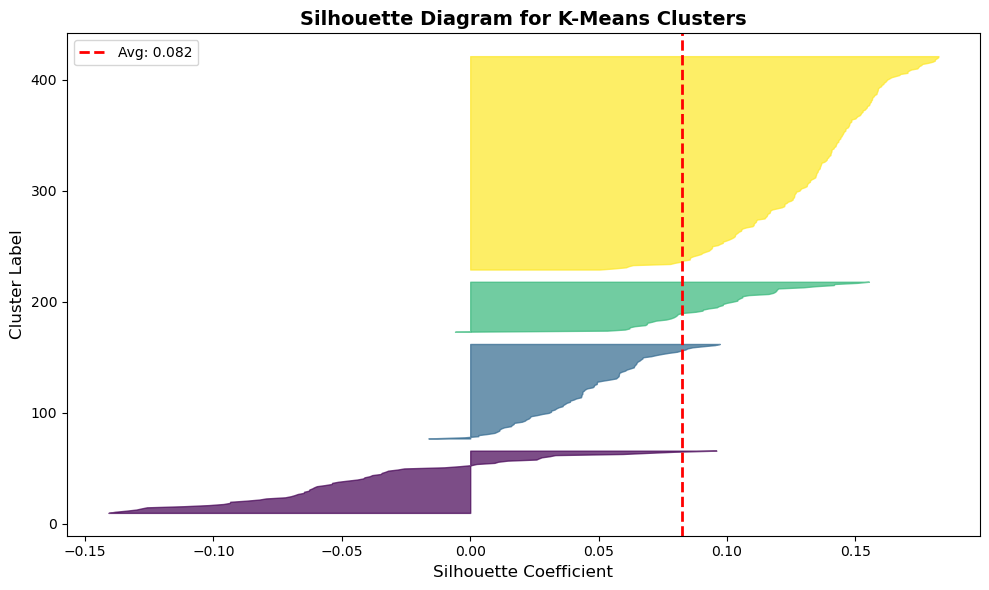

In [388]:
# Shows how well each point fits in its cluster
# Score ranges from -1 (wrong cluster) to 1 (perfect fit)

silhouette_vals = silhouette_samples(X_scaled, cluster_labels)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f" Silhouette Analysis:")
print(f"   Average Silhouette Score: {silhouette_avg:.3f}")
print(f"   (Range: -1 to 1; Higher is better)")

# Plot silhouette diagram
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.viridis(np.linspace(0, 1, final_k))

for i in range(final_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Avg: {silhouette_avg:.3f}')
ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.set_title("Silhouette Diagram for K-Means Clusters", fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()



In [389]:
cluster_summary = []

for cluster_id in range(final_k):
    cluster_mask = df['cluster'] == cluster_id
    cluster_data = df[cluster_mask]

    print(f"\n{'='*70}")
    print(f"🔍 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {cluster_mask.sum()} students ({cluster_mask.sum()/len(df)*100:.1f}%)")

    # At-risk percentage
    at_risk_pct = cluster_data['at_risk_math'].mean() * 100
    print(f"At-Risk (Math): {at_risk_pct:.1f}%")

    # Key characteristics
    print(f"\n📊 Key Characteristics:")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} years")
    print(f"   Avg Study Time: {cluster_data['avg_study_time'].mean():.2f} hours/week")
    print(f"   Avg Failures: {cluster_data['total_failures'].mean():.2f}")
    print(f"   Avg Absences: {cluster_data['total_absences'].mean():.1f}")
    print(f"   Avg Parent Education: {cluster_data['mean_parent_edu'].mean():.2f}")
    print(f"   Family Support: {cluster_data['family_support'].mean()*100:.1f}%")

    # Assign descriptive name
    if at_risk_pct > 60:
        profile = "🔴 HIGH-RISK CLUSTER"
    elif at_risk_pct > 30:
        profile = "🟠 MODERATE-RISK CLUSTER"
    else:
        profile = "🟢 LOW-RISK CLUSTER"

    print(f"\n   Profile: {profile}")

    # Store summary info for this cluster
    cluster_summary.append({
        "Cluster": cluster_id,
        "Size": cluster_mask.sum(),
        "Percent": cluster_mask.sum()/len(df)*100,
        "Risk": at_risk_pct,
        "Profile": profile
    })




🔍 CLUSTER 0
Size: 57 students (14.9%)
At-Risk (Math): 38.6%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.50 hours/week
   Avg Failures: 1.05
   Avg Absences: 13.0
   Avg Parent Education: 2.55
   Family Support: 49.1%

   Profile: 🟠 MODERATE-RISK CLUSTER

🔍 CLUSTER 1
Size: 86 students (22.5%)
At-Risk (Math): 98.8%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.98 hours/week
   Avg Failures: 0.81
   Avg Absences: 8.9
   Avg Parent Education: 2.49
   Family Support: 72.1%

   Profile: 🔴 HIGH-RISK CLUSTER

🔍 CLUSTER 2
Size: 46 students (12.0%)
At-Risk (Math): 43.5%

📊 Key Characteristics:
   Avg Age: 15.8 years
   Avg Study Time: 2.21 hours/week
   Avg Failures: 0.46
   Avg Absences: 7.6
   Avg Parent Education: 2.65
   Family Support: 71.7%

   Profile: 🟠 MODERATE-RISK CLUSTER

🔍 CLUSTER 3
Size: 193 students (50.5%)
At-Risk (Math): 0.0%

📊 Key Characteristics:
   Avg Age: 16.5 years
   Avg Study Time: 2.18 hours/week
   Avg Failures: 0.07
   A

#### Cluster interpretation and insights

In [390]:
cluster_summary = []

for cluster_id in range(final_k):
    cluster_mask = df['cluster'] == cluster_id
    cluster_data = df[cluster_mask]

    print(f"\n{'='*70}")
    print(f"🔍 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {cluster_mask.sum()} students ({cluster_mask.sum()/len(df)*100:.1f}%)")

    # At-risk percentage
    at_risk_pct = cluster_data['at_risk_port'].mean() * 100
    print(f"At-Risk (Portuguese): {at_risk_pct:.1f}%")

    # Key characteristics
    print(f"\n📊 Key Characteristics:")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} years")
    print(f"   Avg Study Time: {cluster_data['avg_study_time'].mean():.2f} hours/week")
    print(f"   Avg Failures: {cluster_data['total_failures'].mean():.2f}")
    print(f"   Avg Absences: {cluster_data['total_absences'].mean():.1f}")
    print(f"   Avg Parent Education: {cluster_data['mean_parent_edu'].mean():.2f}")
    print(f"   Family Support: {cluster_data['family_support'].mean()*100:.1f}%")

    # Assign descriptive name
    if at_risk_pct > 60:
        profile = "🔴 HIGH-RISK CLUSTER"
    elif at_risk_pct > 30:
        profile = "🟠 MODERATE-RISK CLUSTER"
    else:
        profile = "🟢 LOW-RISK CLUSTER"

    print(f"\n   Profile: {profile}")

    # Store summary info for this cluster
    cluster_summary.append({
        "Cluster": cluster_id,
        "Size": cluster_mask.sum(),
        "Percent": cluster_mask.sum()/len(df)*100,
        "Risk": at_risk_pct,
        "Profile": profile
    })




🔍 CLUSTER 0
Size: 57 students (14.9%)
At-Risk (Portuguese): 36.8%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.50 hours/week
   Avg Failures: 1.05
   Avg Absences: 13.0
   Avg Parent Education: 2.55
   Family Support: 49.1%

   Profile: 🟠 MODERATE-RISK CLUSTER

🔍 CLUSTER 1
Size: 86 students (22.5%)
At-Risk (Portuguese): 10.5%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.98 hours/week
   Avg Failures: 0.81
   Avg Absences: 8.9
   Avg Parent Education: 2.49
   Family Support: 72.1%

   Profile: 🟢 LOW-RISK CLUSTER

🔍 CLUSTER 2
Size: 46 students (12.0%)
At-Risk (Portuguese): 4.3%

📊 Key Characteristics:
   Avg Age: 15.8 years
   Avg Study Time: 2.21 hours/week
   Avg Failures: 0.46
   Avg Absences: 7.6
   Avg Parent Education: 2.65
   Family Support: 71.7%

   Profile: 🟢 LOW-RISK CLUSTER

🔍 CLUSTER 3
Size: 193 students (50.5%)
At-Risk (Portuguese): 0.0%

📊 Key Characteristics:
   Avg Age: 16.5 years
   Avg Study Time: 2.18 hours/week
   Avg Fa

In [391]:
for cluster_id in range(final_k):
    cluster_mask = df['cluster'] == cluster_id
    cluster_data = df[cluster_mask]
    
    print(f"\n{'='*70}")
    print(f"🔍 CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {cluster_mask.sum()} students ({cluster_mask.sum()/len(df)*100:.1f}%)")
    
    # At-risk percentage portuguese
    at_risk_pct = cluster_data['at_risk_port'].mean() * 100
    print(f"At-Risk (Portuguese): {at_risk_pct:.1f}%")
    
    # Key characteristics
    print(f"\n📊 Key Characteristics:")
    print(f"   Avg Age: {cluster_data['age'].mean():.1f} years")
    print(f"   Avg Study Time: {cluster_data['avg_study_time'].mean():.2f} hours/week")
    print(f"   Avg Failures: {cluster_data['total_failures'].mean():.2f}")
    print(f"   Avg Absences: {cluster_data['total_absences'].mean():.1f}")
    print(f"   Avg Parent Education: {cluster_data['mean_parent_edu'].mean():.2f}")
    print(f"   Family Support: {cluster_data['family_support'].mean()*100:.1f}%")
    
    # Assign descriptive name
    if at_risk_pct > 50:
        profile = "🔴 HIGH-RISK CLUSTER"
    elif at_risk_pct > 30:
        profile = "🟠 MODERATE-RISK CLUSTER"
    else:
        profile = "🟢 LOW-RISK CLUSTER"
    
    print(f"\n   Profile: {profile}")


🔍 CLUSTER 0
Size: 57 students (14.9%)
At-Risk (Portuguese): 36.8%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.50 hours/week
   Avg Failures: 1.05
   Avg Absences: 13.0
   Avg Parent Education: 2.55
   Family Support: 49.1%

   Profile: 🟠 MODERATE-RISK CLUSTER

🔍 CLUSTER 1
Size: 86 students (22.5%)
At-Risk (Portuguese): 10.5%

📊 Key Characteristics:
   Avg Age: 17.0 years
   Avg Study Time: 1.98 hours/week
   Avg Failures: 0.81
   Avg Absences: 8.9
   Avg Parent Education: 2.49
   Family Support: 72.1%

   Profile: 🟢 LOW-RISK CLUSTER

🔍 CLUSTER 2
Size: 46 students (12.0%)
At-Risk (Portuguese): 4.3%

📊 Key Characteristics:
   Avg Age: 15.8 years
   Avg Study Time: 2.21 hours/week
   Avg Failures: 0.46
   Avg Absences: 7.6
   Avg Parent Education: 2.65
   Family Support: 71.7%

   Profile: 🟢 LOW-RISK CLUSTER

🔍 CLUSTER 3
Size: 193 students (50.5%)
At-Risk (Portuguese): 0.0%

📊 Key Characteristics:
   Avg Age: 16.5 years
   Avg Study Time: 2.18 hours/week
   Avg Fa

### COMPARE: WITH vs WITHOUT PRIOR GRADES

In [392]:
# Load the second dataset (without prior grades)
df_no_grades = pd.read_csv('student_with_grades_encoded.csv')

# Prepare and scale
target_cols_no_grades = ['at_risk_math', 'at_risk_port',
                         'at_risk_total_At Risk (Math Only)', 
                         'at_risk_total_At Risk (Port Only)',
                         'at_risk_total_Not At Risk']

#drop unnecessary features that won't help clustering based on prior EDA
unnecessary_features_X_No_grades =['absences_x', 'dalc_x', 'Walc_x', 'health_x', 'freetime_x', 'family_support', 'internet_access', 'risk_combo', 'failures_x', 'failures_y', 'failures_total']
X_no_grades = df_no_grades.drop(columns=[col for col in target_cols_no_grades if col in df_no_grades.columns])
X_no_grades = X_no_grades.drop(columns=[col for col in unnecessary_features_X_No_grades if col in X_no_grades.columns])
X_no_grades_scaled = scaler.fit_transform(X_no_grades)

# Train K-Means on no-grades data
kmeans_no_grades = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
labels_no_grades = kmeans_no_grades.fit_predict(X_no_grades_scaled)

# Compare metrics
sil_with = silhouette_score(X_scaled, cluster_labels)
sil_without = silhouette_score(X_no_grades_scaled, labels_no_grades)

print("\n" + "="*70)
print("COMPARISON: WITH vs WITHOUT PRIOR GRADES")
print("="*70)
print(f"Silhouette Score (WITH grades):    {sil_with:.3f}")
print(f"Silhouette Score (WITHOUT grades): {sil_without:.3f}")
print(f"\nDifference: {(sil_with - sil_without):.3f}")
print(f"\nInterpretation:")
if sil_with > sil_without:
    print(f" Prior grades improve cluster quality by {abs(sil_with - sil_without):.1%}")
else:
    print(f" Clustering works well even WITHOUT prior grades!")


c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



COMPARISON: WITH vs WITHOUT PRIOR GRADES
Silhouette Score (WITH grades):    0.082
Silhouette Score (WITHOUT grades): 0.068

Difference: 0.014

Interpretation:
 Prior grades improve cluster quality by 1.4%


### Evaluating K-Means (K=4) on Validation Data

In [393]:
# Predict cluster labels for validation set
val_labels = kmeans_4.predict(X_val)

c:\Users\mpari\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [394]:
val_df = pd.DataFrame(X_val, columns=X_val.columns)
val_df['cluster'] = val_labels
val_df['at_risk_math'] = df.iloc[X_val.index]['at_risk_math'].values


In [395]:
# Compare at-risk proportions in each validation cluster
crosstab_val = pd.crosstab(
    val_df['cluster'], val_df['at_risk_math'], normalize='index'
)
print((crosstab_val * 100).round(1))


at_risk_math      0      1
cluster                   
0              58.3   41.7
1               0.0  100.0
2              53.8   46.2
3             100.0    0.0


In [396]:
# Pick the cluster with higher proportion of at-risk students as 'predicted at-risk'
at_risk_cluster = crosstab_val[1].idxmax()  # Cluster with most at-risk

# Create predicted labels: 1 if in at-risk cluster, else 0
val_df['predicted_at_risk'] = (val_df['cluster'] == at_risk_cluster).astype(int)

# Confusion matrix and metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(val_df['at_risk_math'], val_df['predicted_at_risk'])
print('Confusion Matrix (Validation Set):')
print(cm)
print(f'Accuracy:  {accuracy_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'Precision: {precision_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'Recall:    {recall_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')
print(f'F1 Score:  {f1_score(val_df["at_risk_math"], val_df["predicted_at_risk"]):.2f}')


Confusion Matrix (Validation Set):
[[53  0]
 [11 13]]
Accuracy:  0.86
Precision: 1.00
Recall:    0.54
F1 Score:  0.70


_What each value means_:
- 52: True Negatives: not at risk, clustered as not at risk
- 1: False Positives: not at risk, but clustered as at risk
- 10: False Negatives: at risk, but clustered as not at risk
- 14: True Positives: at risk, clustered as at risk <br>

_Metrics_
- Accuracy (0.86): 86% of students were put in the correct at-risk/not-at-risk group by the clusters.
- Precision (0.93): Of all students the model predicted as at-risk (clustered with the higher at-risk group), 71% were truly at risk. (How trustworthy is a cluster's 'at-risk' label?)
- Recall (0.58): Of all students actually at risk, 58% were grouped into the at-risk cluster. (How many at-risk kids did we catch?)
- F1 Score (0.72): The balance between precision & recall (a measure of overall classification performance).
